In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from nltk import word_tokenize
import seaborn as sns
import warnings
import wordcloud
from collections import Counter
from pprint import pprint
import random
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [288]:
df=pd.read_csv("reddit_wsb.csv")
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [289]:
df.describe()

,score,comms_num,created
count,53187.000000,53187.000000,5.318700e+04
mean,1382.461053,263.260252,1.614582e+09
std,7999.271074,2532.665113,4.173566e+06
min,0.000000,0.000000,1.601340e+09
25%,2.000000,3.000000,1.611882e+09
50%,37.000000,17.000000,1.612488e+09
75%,207.000000,60.000000,1.615347e+09
max,348241.000000,93268.000000,1.629095e+09


In [290]:
df['timestamp'] = pd.to_datetime(df['timestamp'], 
                                    format='%Y-%m-%dT%H:%M:%S.%f')
df.dtypes

title                object
score                 int64
id                   object
url                  object
comms_num             int64
created             float64
body                 object
timestamp    datetime64[ns]
dtype: object

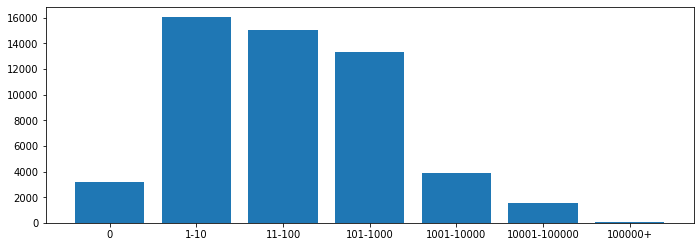

In [291]:
scores = {"0":0, "1-10":0, "11-100":0, "101-1000":0, "1001-10000":0, "10001-100000":0, "100000+":0}

for i in df['score']:
    if i < 1:
        scores["0"] += 1
    elif i < 11:
        scores["1-10"] += 1
    elif i < 101:
        scores["11-100"] += 1
    elif i < 1001:
        scores["101-1000"] += 1
    elif i < 10001:
        scores["1001-10000"] += 1
    elif i < 100001:
        scores["10001-100000"] += 1
    else:
        scores["100000+"] += 1

fig = plt.figure(figsize=(9, 3))
ax = fig.add_axes([0,0,1,1])
score_label = ["0", "1-10", "11-100", "101-1000", "1001-10000", "10001-100000", "100000+"]
value = [scores["0"], scores["1-10"], scores["11-100"], scores["101-1000"], scores["1001-10000"], scores["10001-100000"], scores["100000+"]]
ax.bar(score_label,value)
plt.show()


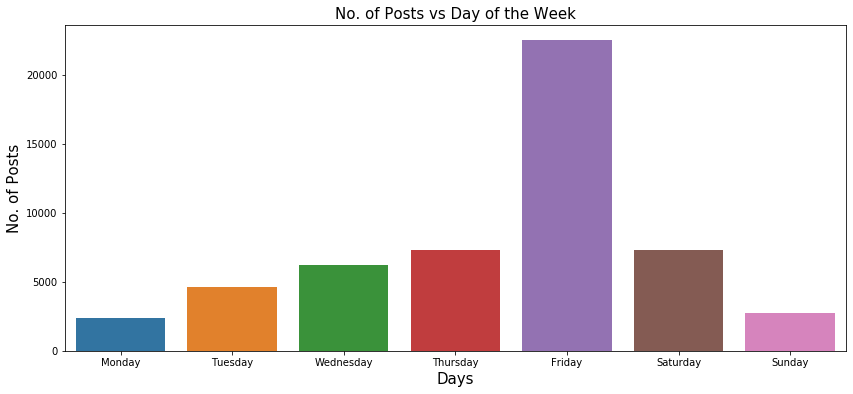

In [292]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

day_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
days_order = list(day_of_the_week.values())

df['Weekday'] = df['timestamp'].apply(lambda x : day_of_the_week[x.weekday()])

xs = df['Weekday'].value_counts().index
ys = df['Weekday'].value_counts().values

plt.figure(figsize=(14,6))

sns.barplot(x=xs, y=ys, order=days_order)

plt.title("No. of Posts vs Day of the Week", fontsize=15)

plt.xlabel("Days", fontsize=15)
plt.ylabel("No. of Posts", fontsize=15)

plt.show()

In [293]:
##creating year, mont, dayofweek, hour, min, second columns for eda
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df['min'] = df['timestamp'].dt.minute
df['sec'] = df['timestamp'].dt.second

##we can get name of the days if we need to.
##dayoftheweek = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
##days = list(dayoftheweek.values())
##df['day'] = df['timestamp'].apply(lambda x : dayoftheweek[x.weekday()])

In [294]:
df["body"] = df["body"].fillna("")##fill nan's with empty
df["original_text"] = df["title"] + ' ' + df["body"]##concatane body and title to create a new column called text
df['length'] = df['original_text'].apply(len) #create new column with the length of the text
df = df.drop(columns = ["body", "title", "id", "url", "created"])##drop unrelated columns

In [295]:
#convert date column to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'], 
                                    format='%Y-%m-%dT%H:%M:%S.%f')
df.dtypes

score                     int64
comms_num                 int64
timestamp        datetime64[ns]
Weekday                  object
year                      int64
month                     int64
day                       int64
hour                      int64
min                       int64
sec                       int64
original_text            object
length                    int64
dtype: object

In [302]:
def clean_text_date(text):
    text = text.lower()
    
    # remove emojis
    text = text.encode('ascii','ignore')
    text = text.decode()

    # replacing handlers with empty string
    text = re.sub('@[^\s]+',"",text)
    
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # replacing URLs with empty string
    text = re.sub(r"http\S+", "",text)

    # remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # replacing single characters with empty string
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if not word in set(stopwords.words('english'))])
    
    # words to singular forms
    lem = WordNetLemmatizer()
    text = lem.lemmatize(text)
    
    return text

In [303]:
df["text"] = df["original_text"].apply(lambda x : clean_text_date(x))

KeyboardInterrupt: 

In [304]:
df2=pd.read_csv("wsb_cleaned.csv")
df2.head()

,score,comms_num,timestamp,original_text,text
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",money sending message
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,math professor scott steiner says numbers spel...
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,new sec filing gme someone less retarded pleas...
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware


#### Most frequent unigram words

In [305]:
from collections import Counter 

counter = Counter()

for text in df.original_text:
    doc = nlp(text)
    counter.update([token.text for token in doc])

In [306]:
most_common_unigrams = counter.most_common()[0:30]
words = [item[0] for item in most_common_unigrams]
freq = [item[1] for item in most_common_unigrams]

C:\Users\22234\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 55357 missing from current font.

C:\Users\22234\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 56960 missing from current font.

C:\Users\22234\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning:

Glyph 128640 missing from current font.



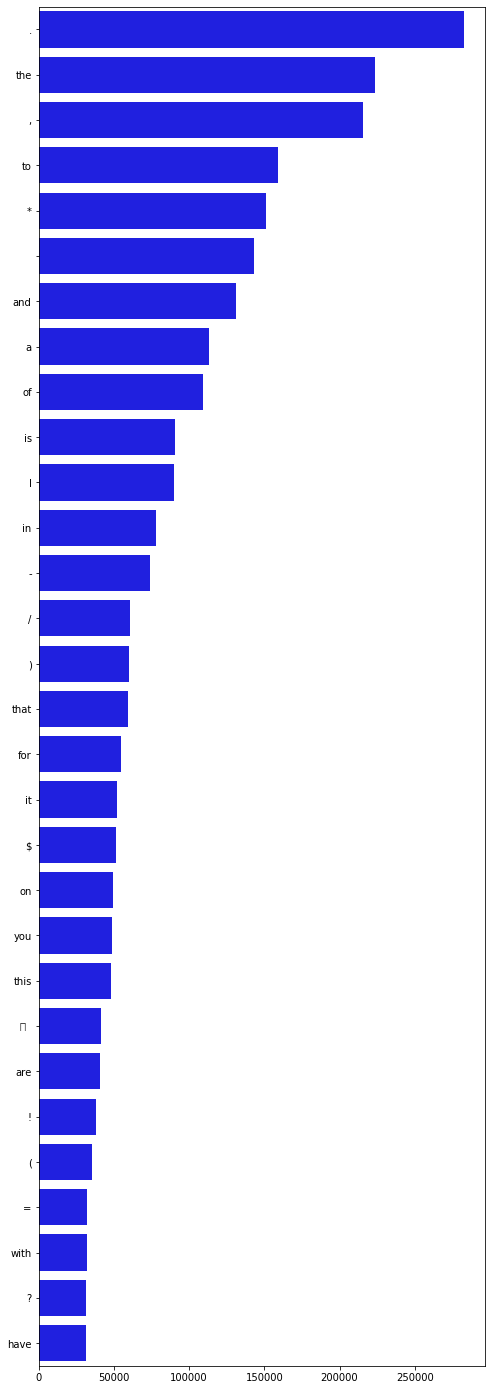

In [307]:
plt.figure(figsize=(8, 25))
sns.barplot(y=words, x=freq, color='blue')

In [203]:
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [206]:
bigram_counter = Counter()

for text in df.text:
    bigram_counter.update(generate_ngrams(text, 2))

In [207]:
most_common_bigrams = bigram_counter.most_common()[0:30]
bigrams = [item[0] for item in most_common_bigrams]
bi_freq = [item[1] for item in most_common_bigrams]

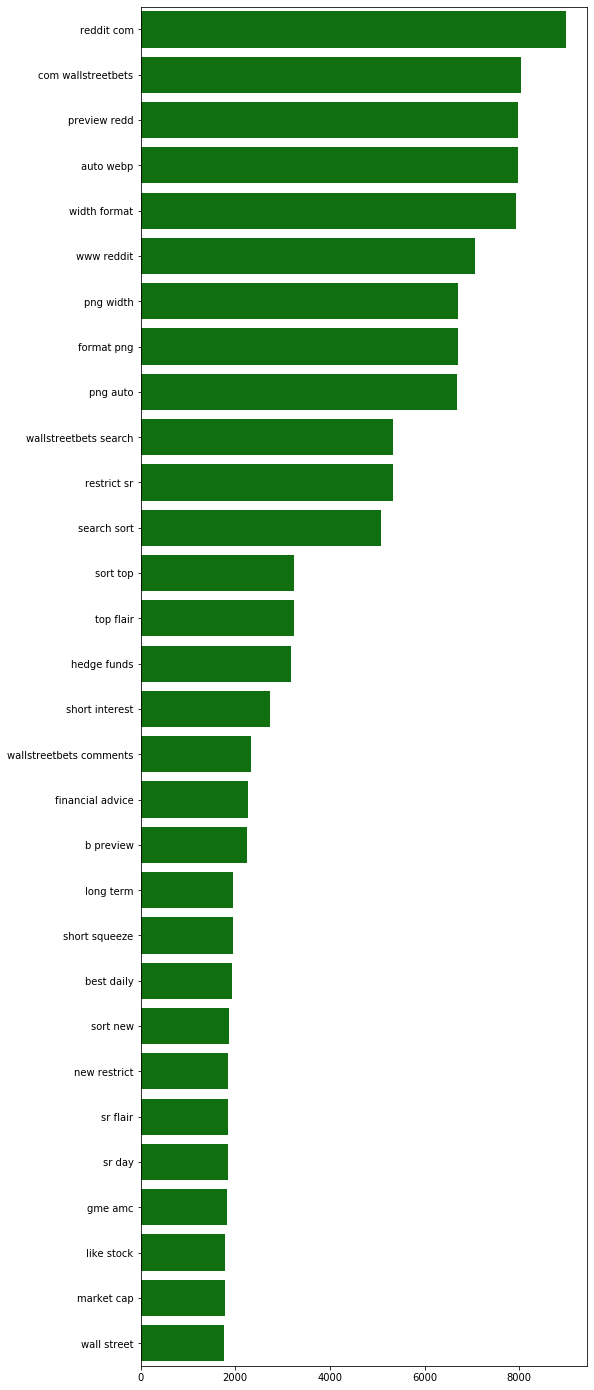

In [208]:
plt.figure(figsize=(8, 25))
sns.barplot(y=bigrams, x=bi_freq, color='green')

In [243]:
import plotly.express as px

In [225]:
df['len']=df['original_text'].apply(lambda x : len(x.split(' ')))
px.histogram(df['len'],template='plotly_dark')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000259E1303688>],
      dtype=object)

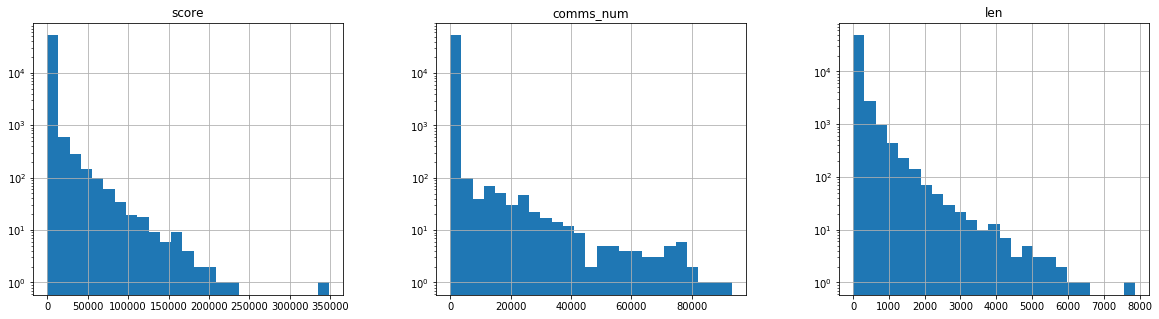

In [232]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
df.hist(column=['score'], bins = 25, ax = ax[0])
df.hist(column=['comms_num'], bins = 25, ax = ax[1])
df.hist(column=['len'], bins = 25, ax = ax[2])

In [237]:
df.sort_values(by='score', ascending = False).head(5)


,score,comms_num,timestamp,Weekday,year,month,day,hour,min,sec,original_text,length,text,len
19162,348241,11554,2021-01-31 04:00:38,Sunday,2021,1,6,4,0,38,Times Square right now,23,times square right,5
16009,225870,23309,2021-01-29 07:06:23,Friday,2021,1,4,7,6,23,GME YOLO update — Jan 28 2021,30,gme yolo update jan,8
17771,219779,20105,2021-01-30 07:04:45,Saturday,2021,1,5,7,4,45,GME YOLO month-end update — Jan 2021,37,gme yolo month end update jan,8
34179,201168,12846,2021-02-20 07:05:55,Saturday,2021,2,5,7,5,55,GME YOLO update — Feb 19 2021,30,gme yolo update feb,8
18273,195782,4523,2021-01-30 09:40:59,Saturday,2021,1,5,9,40,59,It’s treason then,18,treason,4


In [239]:
df.sort_values(by='comms_num', ascending = False).head(5)

,score,comms_num,timestamp,Weekday,year,month,day,hour,min,sec,original_text,length,text,len
39993,47667,93268,2021-03-10 23:30:11,Wednesday,2021,3,2,23,30,11,"GME Megathread for March 10, 2021 HOLYMOLYHOLY...",514,gme megathread march holymolyholymolyholymolyh...,7
17095,12288,89050,2021-01-29 21:00:15,Friday,2021,1,4,21,0,15,"Daily Discussion Thread for January 29, 2021 Y...",2438,daily discussion thread january daily trading ...,128
35110,28975,83094,2021-02-25 00:24:58,Thursday,2021,2,3,0,24,58,"GME Megathread for Wednesday, February 24th, 2...",115,gme megathread wednesday february th enjoy thr...,19
17249,7348,80926,2021-01-30 02:23:51,Saturday,2021,1,5,2,23,51,"Daily Discussion Thread for January 29, 2021 -...",2430,daily discussion thread january pt ii daily tr...,87
17313,29356,80586,2021-01-30 01:26:04,Saturday,2021,1,5,1,26,4,GME What About Second Breakfast Club Megathread,48,gme second breakfast club megathread,8
